In [2]:
######
# AstroPlanner_VTS - v20191026
# Mireia Nievas <mireia.nievas-rosillo@desy.de
######

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.cbook as cbook
import matplotlib.colors as mcolors
import datetime
import time

import astropy
import astropy.units as u
from astropy.coordinates import EarthLocation
from astropy.time import Time,TimeDelta
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5
from astroquery.simbad import Simbad
from astroquery.ned import Ned

from astroquery.simbad import Simbad

import astroplan
from astroplan import Observer,FixedTarget
from astroplan.plots import plot_sky,plot_airmass,plot_altitude


import logging

logging.addLevelName( logging.DEBUG, "\033[1;36m%s\033[1;0m" % logging.getLevelName(logging.INFO))
logging.addLevelName( logging.INFO, "\033[0;32m%s\033[1;0m" % logging.getLevelName(logging.INFO))
logging.addLevelName( logging.WARNING, "\033[1;31m%s\033[1;0m" % logging.getLevelName(logging.WARNING))
logging.addLevelName( logging.ERROR, "\033[1;41m%s\033[1;0m" % logging.getLevelName(logging.ERROR))
logging.root.setLevel("INFO")

time.sleep(1)
mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('axes',facecolor = (1,1,1,1))
mpl.rc('figure',facecolor = (1,1,1,1))
mpl.rc('text', usetex=True)
mpl.rc('figure',figsize=(4.2,2.4))
mpl.rc('figure',dpi=100)
mpl.rc('savefig',dpi=100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
srcname = "M87"
src = FixedTarget.from_name(srcname)
#float(src['RA']), float(src['DEC']), float(src['Redshift'])

In [19]:
flwo = Observer(latitude=31.6716989799*u.deg, 
                longitude=-110.951291195*u.deg,
                elevation=1.268*u.m, 
                name='FLWO',
                timezone="America/Phoenix")

In [20]:
#vega = FixedTarget.from_name('Vega')
#pg1553=FixedTarget(SkyCoord("15 55 43 +11 11 24",
#                    frame='icrs',unit=(u.hourangle,u.deg)),
#                    name="PG1553+113")

timenow = Time.now()
sunset_tonight   = flwo.sun_set_time(timenow, which='nearest')
sunrise_tomorrow = flwo.sun_rise_time(timenow+TimeDelta(0.5*u.day), 
                                                    which='nearest')

In [21]:
from math import atan2,degrees
import numpy as np

#Label line with line2D label data
def labelLine(line,x,label=None,align=True,**kwargs):

    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if (x < xdata[0]) or (x > xdata[-1]):
        print('x label location is outside data range!')
        return

    #Find corresponding y co-ordinate and angle of the line
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break

    y = ydata[ip-1] + (ydata[ip]-ydata[ip-1])*(x-xdata[ip-1])/(xdata[ip]-xdata[ip-1])

    if not label:
        label = line.get_label()

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0

    #Set a bunch of keyword arguments
    if 'color' not in kwargs:
        kwargs['color'] = line.get_color()

    if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
        kwargs['ha'] = 'center'

    if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
        kwargs['va'] = 'center'

    if 'backgroundcolor' not in kwargs:
        kwargs['backgroundcolor'] = ax.get_facecolor()

    if 'clip_on' not in kwargs:
        kwargs['clip_on'] = True

    if 'zorder' not in kwargs:
        kwargs['zorder'] = 2.5

    ax.text(x,y,label,rotation=trans_angle,**kwargs)

def labelLines(lines,align=True,xvals=None,**kwargs):

    ax = lines[0].axes
    labLines = []
    labels = []

    #Take only the lines which have labels other than the default ones
    for line in lines:
        label = line.get_label()
        if "_line" not in label:
            labLines.append(line)
            labels.append(label)

    if xvals is None:
        xmin,xmax = ax.get_xlim()
        xvals = np.linspace(xmin,xmax,len(labLines)+2)[1:-1]

    for line,x,label in zip(labLines,xvals,labels):
        labelLine(line,x,label,align,**kwargs)

In [74]:
class Scheduler(object):
    def __init__(self):
        self.set_site()
        self.create_figure()
        self.targets = []
    
    def from_srcname(self,name):
        self.src = FixedTarget.from_name(name)
        if self.src not in self.targets:
            self.targets.append(self.src)
        
    def from_radec_coords(self,RA,DEC,name='Custom'):
        coord = SkyCoord(ra=RA,dec=DEC)
        self.src = FixedTarget(coord=coord,name=name)
        if self.src not in self.targets:
            self.targets.append(self.src)
        
    def set_site(self):
        self.site = Observer(\
            latitude=31.6716989799*u.deg, 
            longitude=-110.951291195*u.deg,
            elevation=1.268*u.m, 
            name='FLWO',
            timezone="America/Phoenix")

    def create_figure(self):
        # Create figure and subplots
        self.fig_obs = plt.figure(figsize=(9,3),dpi=120)
        self.ax1 = self.fig_obs.add_subplot(111)
        #self.ax2 = self.fig_obs.add_subplot(122,polar='True')    
    
    def get_src_observability_plots(self):
        site = self.site
        #timenow = Time(self.date)
        timenow = Time(datetime.datetime.now())
        
        midnight          = site.midnight(timenow+TimeDelta(0.5*u.day), which='next')
        sunset_tonight    = site.sun_set_time(timenow+TimeDelta(0*u.day), which='next')
        self.twilight_tonight  = site.twilight_evening_astronomical(timenow+TimeDelta(0*u.day), which='next')
        self.twilight_tomorrow = site.twilight_morning_astronomical(timenow+TimeDelta(0.5*u.day), which='next')
        sunrise_tomorrow  = site.sun_rise_time(timenow+TimeDelta(0.5*u.day),  which='next')
        
        
        print('Sunset: {0}'.format(sunset_tonight.datetime))
        print('Twilight: {0}'.format(self.twilight_tonight.datetime))
        print('Twilight: {0}'.format(self.twilight_tomorrow.datetime))
        print('Sunrise: {0}'.format(sunrise_tomorrow.datetime))
        print('Moon rise: {0}'.format(site.moon_rise_time(midnight).datetime))
        print('Moon set: {0}'.format(site.moon_set_time(midnight).datetime))
        print('Moon phase: {0}'.format(site.moon_illumination(midnight)))
        
        #self.ax2.set_theta_zero_location('N')
        #self.ax2.set_rmax(90)
        #self.ax2.set_yticklabels([])
        #self.ax2.set_ylim(0,90)
        #self.ax2.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])

        plot_times = [
            Time(datetime.datetime.strptime(\
                timenow.datetime.strftime("%Y%m%d")+"000000","%Y%m%d%H%M%S"))+TimeDelta(ki*u.hour)\
            for ki in range(24)]
        
        plot_times_fine = [
            Time(datetime.datetime.strptime(\
                timenow.datetime.strftime("%Y%m%d")+"000000","%Y%m%d%H%M%S"))+TimeDelta(ki*5*u.minute)\
            for ki in range(24*12)]

        for target in self.targets:
            l = plot_altitude(target, site, plot_times_fine, ax=self.ax1,
                airmass_yaxis=True, brightness_shading=True,
                style_kwargs={'lw':2})

        moon_times = np.linspace(self.ax1.get_xlim()[0],self.ax1.get_xlim()[1],100)
        moon_times = Time(moon_times,format='plot_date')
        moon_alts  = site.moon_altaz(moon_times).alt.deg
        moon_alts[moon_alts<=0]=0
        l.plot(moon_times.plot_date,moon_alts, color='black', lw=1.5, ls='dashed')
        l.axhline(30,color='black',lw=1.5, ls='dotted')
        legends = [target.name for target in self.targets]
        legends.append('Moon')
        legends.append('ZD=$60^\circ$')
        l.legend(legends,fontsize='small')
        
        for t in plot_times:
            MyScheduler.ax1.axvline(t.datetime, zorder=1,lw=0.5,alpha=0.3333,ls='dashed',color='white')

        
        
        # Plot az,alt positions of the source and the moon
        timehours = [sunset_tonight+TimeDelta(h*u.hour) for h in np.arange(14)]
        timehours = [t for t in timehours if site.target_is_up(t,self.src) and site.is_night(t)]
        labelhours = [t.datetime.strftime("%H:%M") for t in timehours]

        timehours_fine = [sunset_tonight+TimeDelta(h*u.hour) for h in np.arange(0,14,0.2)]
        timehours_fine = [t for t in timehours_fine if site.target_is_up(t,self.src) and site.is_night(t)]

        #self.ax2.plot(np.linspace(0,2*np.pi,100),60*np.ones(100),color='C3',ls='dotted')

        # Get the positions for the Moon and the source, 
        #   1 hour big scatter dots and 1/5 hour small dots.
        
        az  = site.altaz(timehours,self.src).az.deg
        alt = site.altaz(timehours,self.src).alt.deg
        az_fine  = site.altaz(timehours_fine,self.src).az.deg
        alt_fine = site.altaz(timehours_fine,self.src).alt.deg

        az_moon  = site.moon_altaz(timehours).az.deg
        alt_moon = site.moon_altaz(timehours).alt.deg
        az_moon_fine  = site.moon_altaz(timehours_fine).az.deg
        alt_moon_fine = site.moon_altaz(timehours_fine).alt.deg

        '''
        # Small 1/5 hour dots
        for k,ti in enumerate(timehours_fine):
            self.ax2.scatter(az_fine[k]*np.pi/180.,
                        90.-alt_fine[k],
                        color='C0',s=0.5)
            self.ax2.scatter(az_moon_fine[k]*np.pi/180.,
                        90.-alt_moon_fine[k],
                        color='C2',s=0.5)

        # Big scatter dots every hour starting from 
        for k,ti in enumerate(labelhours):
            self.ax2.scatter(az[k]*np.pi/180.,
                        90.-alt[k],
                        color='C0')
            
            self.ax2.scatter(az_moon[k]*np.pi/180.,
                        90.-alt_moon[k],
                        color='C2')
            
            if (k%2 == 0):
                if alt[k]>0:
                    self.ax2.text(az[k]*np.pi/180.,90.-alt[k], ti,
                             fontsize='x-small',verticalalignment='bottom',
                             horizontalalignment='center',rotation=90)
                if alt_moon[k]>0:
                    self.ax2.text(az_moon[k]*np.pi/180.,90.-alt_moon[k], ti,
                            fontsize='x-small',verticalalignment='bottom',
                            horizontalalignment='center',rotation=90)
        '''

        self.fig_obs.suptitle("Observability from FLWO.", fontsize='large')

        plt.grid()
        
        #self.ax2.grid(ls='dotted')
        #self.fig_obs_filenamerel  = "VIS/{0}.png".format("Observability")
        #self.fig_obs_filenamefull = "{0}/{1}".format(webpath,self.fig_obs_filenamerel)
        #self.fig_obs.savefig(self.fig_obs_filenamefull, dpi=150, bbox_inches='tight', format='png')

Sunset: 2019-10-27 00:35:58.714503
Twilight: 2019-10-27 02:01:48.422157
Twilight: 2019-10-27 12:13:56.025560
Sunrise: 2019-10-27 13:39:54.347329
Moon rise: 2019-10-28 14:08:46.889209
Moon set: 2019-10-28 00:42:59.406689
Moon phase: 0.0018809277164298366


/usr/lib/python3.7/site-packages/astroplan/plots/time_dependent.py:366: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot_date(time.plot_date, masked_altitude, label=target_name, **style_kwargs)


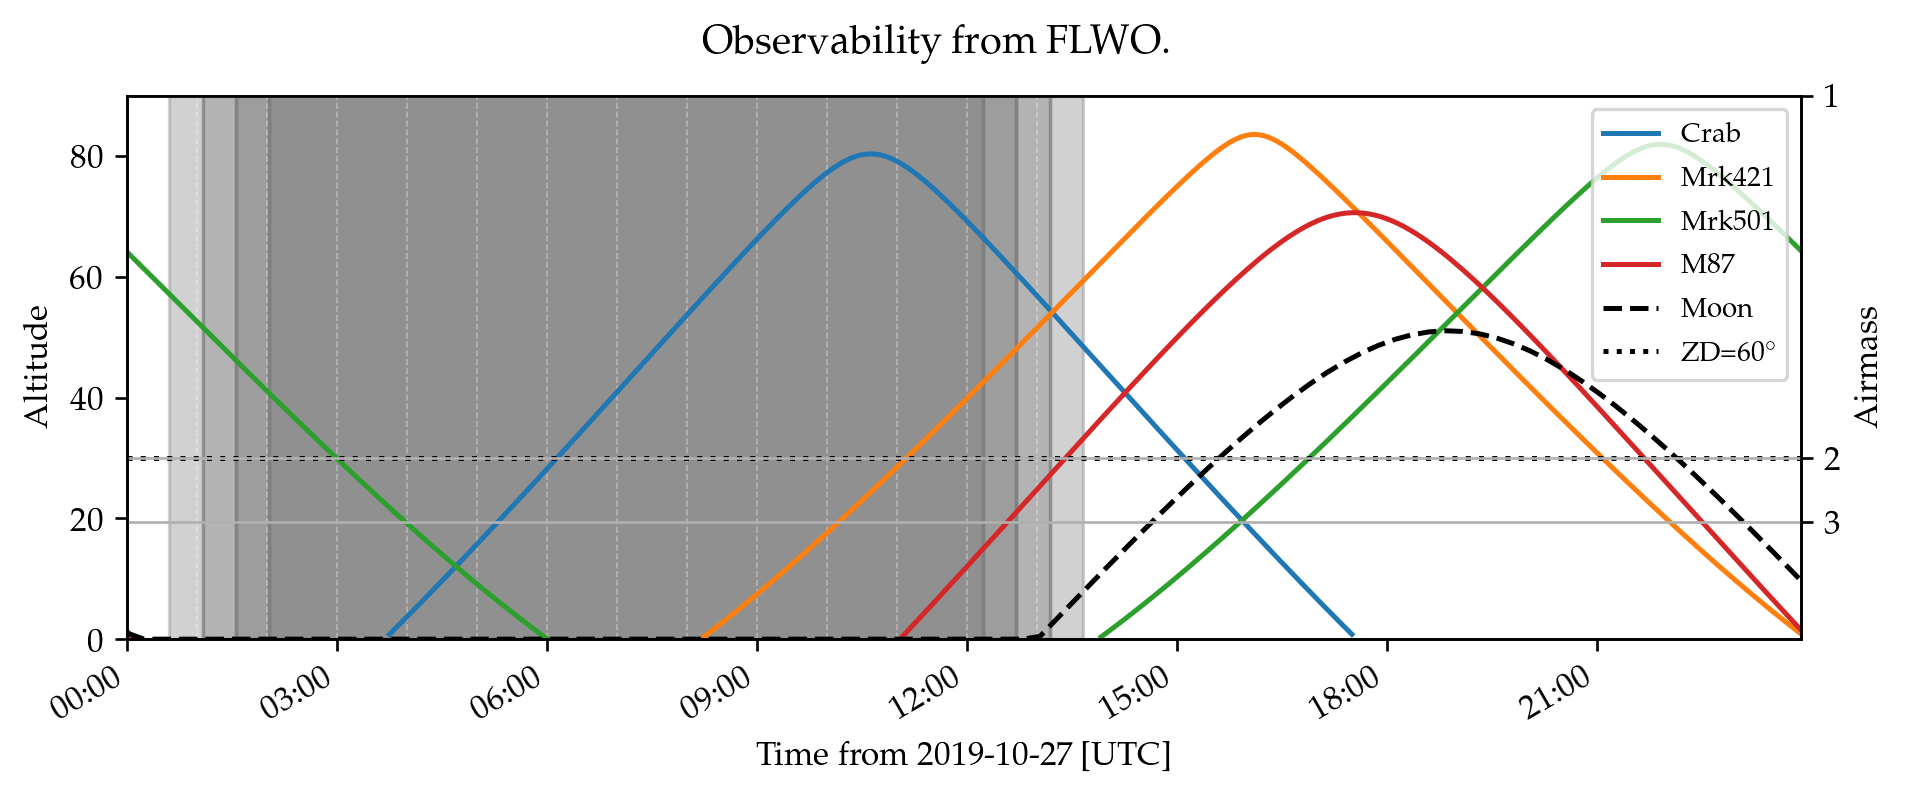

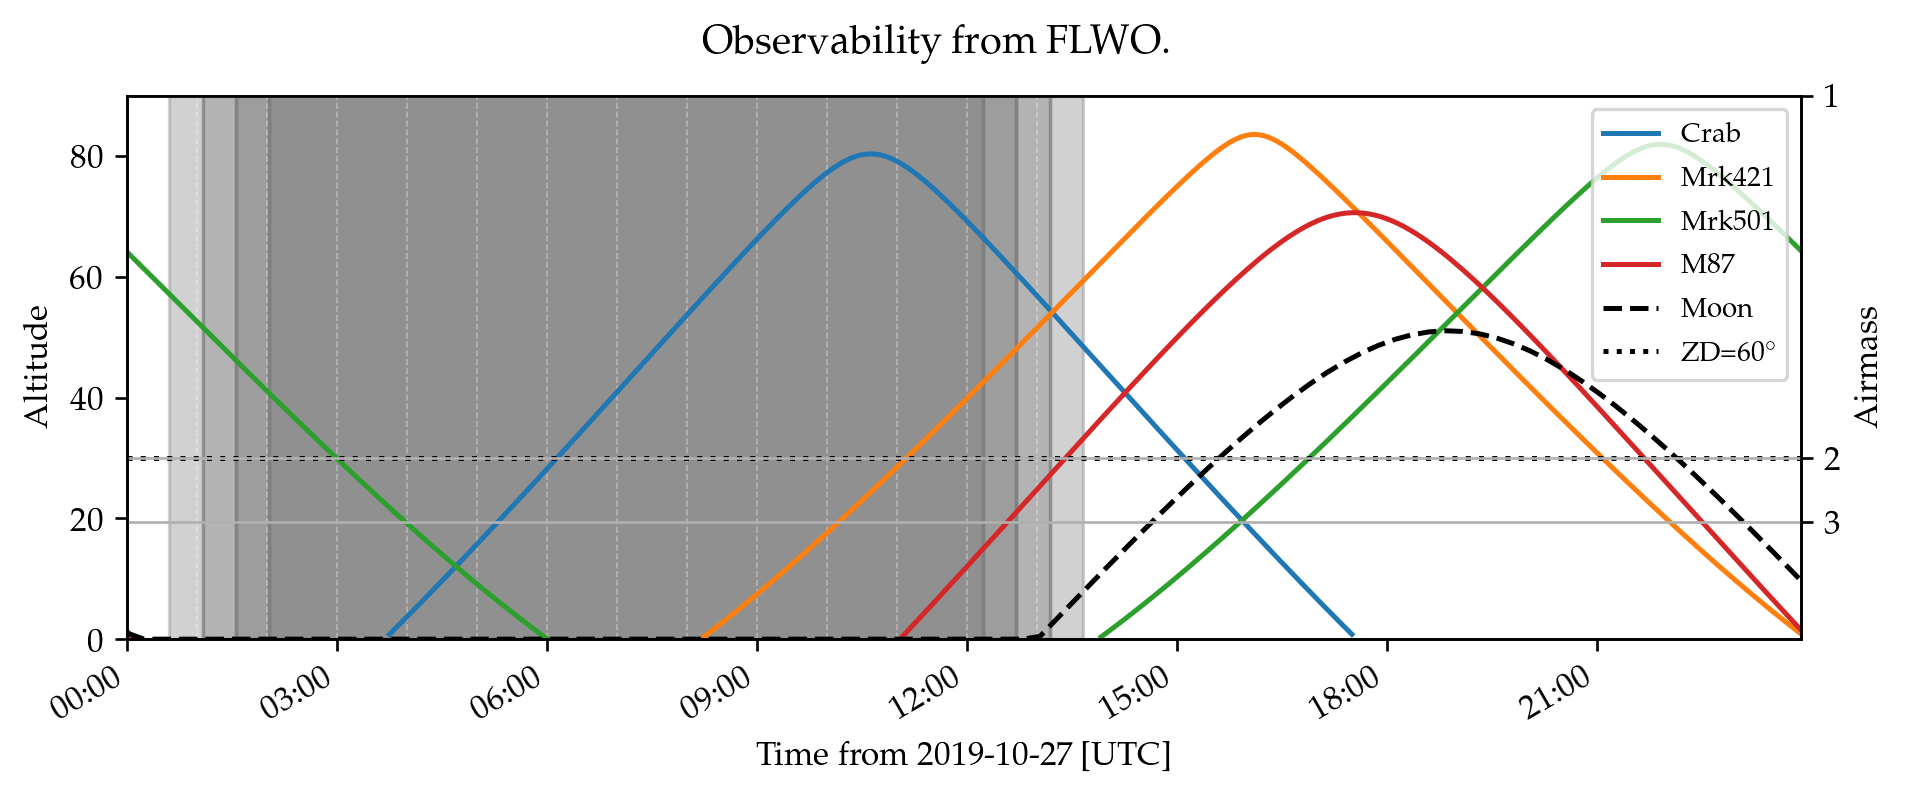

In [75]:
MyScheduler = Scheduler()

# Snapshots and coordinated 
MyScheduler.from_srcname('Crab')
MyScheduler.from_srcname('Mrk421')
MyScheduler.from_srcname('Mrk501')
MyScheduler.from_srcname('M87')

MyScheduler.get_src_observability_plots()
MyScheduler.fig_obs